In [1]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras

MODEL_WEIGHT_FILE = 'vgg.h5'
MODEL_JSON_FILE = 'vgg.json'
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
MEAN = [123.68, 116.779, 103.939]
EPOCHS = 10
BATCH_SIZE = 64
TRAINING_DATA = 'data/training'
VALIDATION_DATA = 'data/validation'
CLASS_MODE = 'binary'

Using TensorFlow backend.


In [2]:
# Load Data
training_data_generator = ImageDataGenerator(featurewise_center=True)
training_data_generator.mean = MEAN

validation_data_generator = ImageDataGenerator(featurewise_center=True)
validation_data_generator.mean = MEAN

training_generator = training_data_generator.flow_from_directory(
    TRAINING_DATA,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE
)
validation_generator = validation_data_generator.flow_from_directory(
    VALIDATION_DATA,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [3]:
# Setup Model
# Load VGG16 model
model = VGG16(include_top=False, input_shape=INPUT_SHAPE)
for layer in model.layers:
    layer.trainable = False

# Add new fully connected layer
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(1, activation='sigmoid')(class1)
model = Model(inputs=model.inputs, outputs=output)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

with open(MODEL_JSON_FILE,"w") as f:
    f.write(model.to_json())

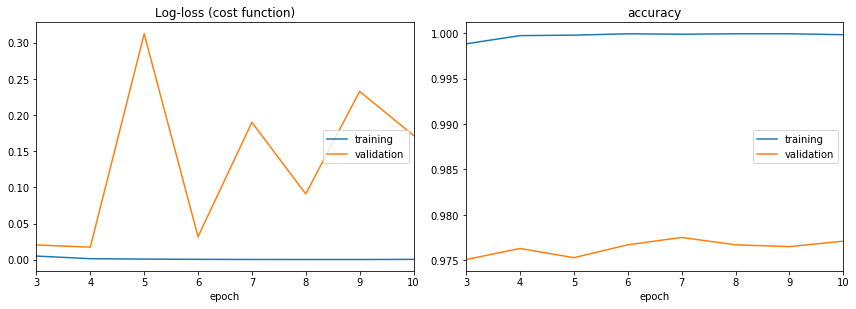

Log-loss (cost function):
training   (min:    0.000, max:    0.205, cur:    0.001)
validation (min:    0.017, max:    0.312, cur:    0.172)

accuracy:
training   (min:    0.965, max:    1.000, cur:    1.000)
validation (min:    0.972, max:    0.978, cur:    0.977)


In [4]:
# Training
model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[PlotLossesKeras()], 
    verbose=1
)

model.save_weights(MODEL_WEIGHT_FILE)